# ハッシュタグのカテゴリ分類の性能比較

自然言語処理（NLP）技術、特にBERT、OpenAIのEmbedding API、ELECTRAを用いて、ハッシュタグのカテゴリ分類を行うアプリケーションです。

このアプリケーションでは、それぞれのモデルを用いてハッシュタグをベクトルに変換し、それを基にハッシュタグのカテゴリを予測します。そして、それぞれの予測結果を評価することで、各モデルの性能を比較します。

In [1]:
import pandas as pd
df = pd.read_csv('input/hashtags.csv')
df_category = pd.DataFrame(df['category'].unique(), columns=['category'])
print(df.groupby('category').count())

              hashtag
category             
アート・デザイン           45
クッキング・レシピ          55
サイエンス・科学           39
スポーツ               49
テクノロジー・ガジェット       50
ビジネス・経済            43
ファッション・ビューティ       43
ブック・文学             38
ライフスタイル・生活         38
健康・ウェルネス           44
政治・社会問題            53
教育・学習              41
旅行・アウトドア           51
映画・ドラマ             51
音楽                 55


## ハッシュタグをベクトルに変換する

In [2]:
import torch
from abc import ABC, abstractmethod
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer

class EmbeddingModel(ABC):
    @abstractmethod
    def convert_to_vector(self, text):
        pass

class BERTModel(EmbeddingModel):
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        
    def convert_to_vector(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
        vector = outputs.last_hidden_state[0, 0, :].numpy().tolist()
        return vector


In [3]:
import time

def add_vector_column(df: pd.DataFrame, model: EmbeddingModel, column: str) -> pd.DataFrame:
    start_time = time.time()

    # 文字列をベクトルに変換して新しい列に追加
    df.loc[:, column+'_vector'] = df[column].apply(model.convert_to_vector)

    # 処理時間の計測終了と結果の出力
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    return df

## ベクトルから最も類似するカテゴリを計算する

In [4]:
import numpy as np

def predict_category(df_hashtag: pd.DataFrame, df_category: pd.DataFrame) -> pd.DataFrame:
    # ベクトルのリストを取得し、NumPy配列に変換
    hashtag_vectors = np.array(df_hashtag['hashtag_vector'].tolist())
    category_vectors = np.array(df_category['category_vector'].tolist())

    # 各ハッシュタグベクトルと全カテゴリベクトルのコサイン類似度を計算
    cosine_similarities = cosine_similarity(hashtag_vectors, category_vectors)

    # 最も類似度が高いカテゴリのインデックスを取得
    predicted_category_indices = np.argmax(cosine_similarities, axis=1)

    # 最大類似度を取得
    max_similarities = np.max(cosine_similarities, axis=1)

    # 予測カテゴリを取得
    predicted_categories = df_category['category'].iloc[predicted_category_indices].values

    # df_hashtagに新しい列を追加
    df_hashtag['predict_category'] = predicted_categories
    df_hashtag['cosine_similarity'] = max_similarities

    return df_hashtag

## カテゴリ分類結果の評価

評価指標

- **Accuracy（精度）**: モデルがクラスを正しく予測した割合。各クラスのサンプル数がバランスしていない場合（不均衡データ）には、この指標はあてにならない。

- **Precision（適合率）**: モデルが正と予測したサンプルのうち、実際に正であったサンプルの割合。偽陽性を避ける指標。

- **Recall（再現率）**: 実際の正のサンプルのうち、モデルが正と予測したサンプルの割合。偽陰性（実際は正だが、予測は負）を避ける指標。

- **F1 Score（F1スコア）**: F1 PrecisionとRecallの調和平均をとったもので、これら2つの評価指標のバランス。F1スコアは、PrecisionとRecallの両方が重要な場合に特に有用。

混同行列のヒートマップ

- **数字**: 「実際のクラス」（行）と「予測されたクラス」（列）の組み合わせがデータセット内で何回発生したかを示す。
- **色の濃さ**: 色の濃さはそのセルの値が相対的にどの程度大きいか。色が濃いほど、その「実際のクラス」と「予測されたクラス」の組み合わせが多く発生した）ことを意味する。

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation(df_predicted: pd.DataFrame):
    # 予測と実際のカテゴリを取得
    y_true = df_predicted['category']
    y_pred = df_predicted['predict_category']

    # 評価指標の計算
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}')

    # 混同行列の作成
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## t-SNEを使ったハッシュタグクラスターの可視化

In [6]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import ast

def visualized_in_2d(df_predicted: pd.DataFrame):
    df_predicted['hashtag_vector'] = df_predicted['hashtag_vector'].apply(ast.literal_eval)
    df_predicted['hashtag_vector'] = df_predicted['hashtag_vector'].apply(lambda x: [float(i) for i in x])

    # df_predictedの'hashtag_vector'列から配列を作成
    matrix = np.array(df_predicted['hashtag_vector'].tolist())

    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    # predict_categoryの一意な値とその色のマッピング
    unique_categories = df_predicted['predict_category'].unique()
    colors = cm.rainbow(np.linspace(0, 1, len(unique_categories)))
    category_color_mapping = {category: color for category, color in zip(unique_categories, colors)}

    for category, color in category_color_mapping.items():
        xs = np.array(x)[df_predicted['predict_category'] == category]
        ys = np.array(y)[df_predicted['predict_category'] == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

    plt.title("Hashtag Clusters visualized in 2D using t-SNE")
    plt.show()

## カテゴリ分類結果

### BERTを使ったカテゴリ分類

In [7]:
# # 1回目のみ
# bert_model = BERTModel()

# # ハッシュタグをベクトル変換してcsv出力
# df_bert = add_vector_column(df, bert_model, 'hashtag')
# df_bert.to_csv('output/hashtags_bert.csv', index=False)

# # カテゴリをベクトル変換してcsv出力
# df_category_bert = add_vector_column(df_category, bert_model, 'category')
# df_category_bert.to_csv('output/categories_bert.csv', index=False)

print('Elapsed time: 32.517783641815186 seconds')
print('Elapsed time: 0.8807814121246338 seconds')

Elapsed time: 32.517783641815186 seconds
Elapsed time: 0.8807814121246338 seconds


In [8]:
# 2回目以降
df_bert = pd.read_csv('output/hashtags_bert.csv')
df_category_bert = pd.read_csv('output/categories_bert.csv')

In [9]:
# # 1回目のみ
# df_bert_predicted = predict_category(df_bert, df_category_bert)
# df_bert_predicted.to_csv('output/hashtags_bert_predicted.csv', index=False)

In [10]:
# 2回目以降
df_bert_predicted = pd.read_csv('output/hashtags_bert_predicted.csv')
df_bert_predicted.head()

,hashtag,category,hashtag_vector,predict_category,cosine_similarity
0,サッカー,スポーツ,"[-0.4107682406902313, -0.5052114129066467, -0....",アート・デザイン,0.952842
1,野球,スポーツ,"[-0.2615754306316376, 0.09152048081159592, -0....",健康・ウェルネス,0.953856
2,ラグビー,スポーツ,"[-0.31610018014907837, -0.8343167304992676, -0...",クッキング・レシピ,0.945390
3,マラソン,スポーツ,"[-0.5356400012969971, 0.5024380683898926, -0.5...",音楽,0.984449
4,バレーボール,スポーツ,"[-0.5938227772712708, -0.46884140372276306, -0...",アート・デザイン,0.968736


Accuracy: 0.12
Precision: 0.15
Recall: 0.12
F1 Score: 0.12


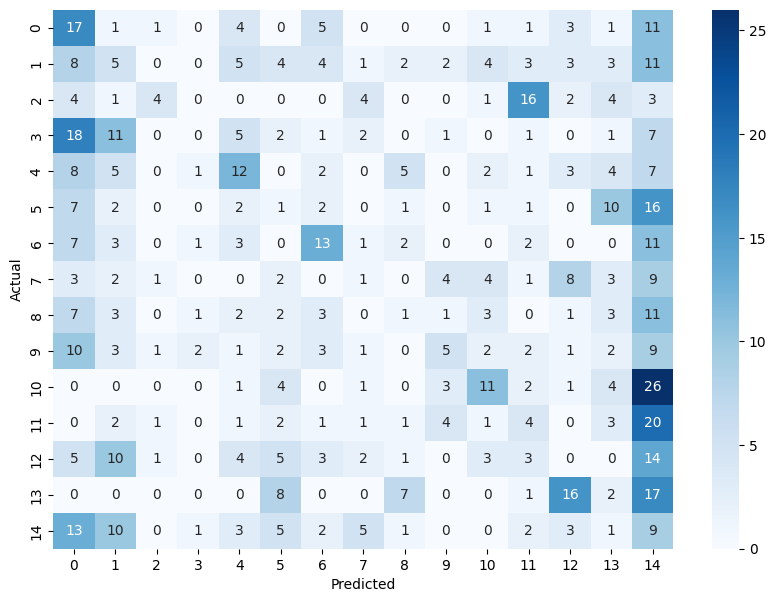

In [11]:
evaluation(df_bert_predicted)

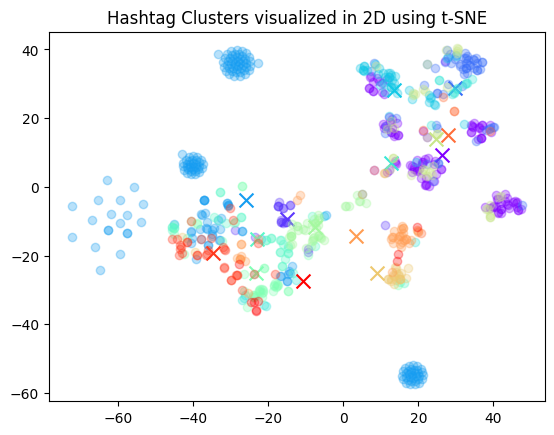

In [12]:
visualized_in_2d(df_bert_predicted)

### OpenAI Embedding APIを使ったカテゴリ分類

In [13]:
import os
import csv
import openai
from openai.embeddings_utils import get_embedding

In [14]:
class OpenAIModel(EmbeddingModel):
    def __init__(self):
        openai.api_key = os.getenv("OPENAI_API_KEY")
        self.openai = openai
        
    def convert_to_vector(self, text):
        response = self.openai.Embedding.create(
          model="text-embedding-ada-002",
          input=text
        )
        
        # 消費したトークン数をCSVに記録
        filename = 'output/openai_usage_tokens.csv'
        file_exists = os.path.isfile(filename)
        
        with open(filename, mode='a') as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(['Text', 'Total Tokens'])
            writer.writerow([text, response['usage']['total_tokens']])
        
        # vectorを返却
        return response['data'][0]['embedding']

https://openai.com/pricing
| Model     | Usage               |
|-----------|---------------------|
| Ada v2    | `$0.0001 / 1K tokens` |
| Ada v1    | `$0.0040 / 1K tokens` |
| Babbage v1| `$0.0050 / 1K tokens` |
| Curie v1  | `$0.0200 / 1K tokens` |
| Davinci v1| `$0.2000 / 1K tokens` |


In [15]:
# # 1回目のみ
# openai_model = OpenAIModel()

# # ハッシュタグをベクトル変換してcsv出力
# df_openai = add_vector_column(df, openai_model, 'hashtag')
# df_openai.to_csv('output/hashtags_openai.csv', index=False)

# # カテゴリをベクトル変換してcsv出力
# df_category_openai = add_vector_column(df_category, openai_model, 'category')
# df_category_openai.to_csv('output/categories_openai.csv', index=False)

print('Elapsed time: 253.96260690689087 seconds')
print('Elapsed time: 4.664952278137207 seconds')

df_openai_usage_tokens = pd.read_csv('output/openai_usage_tokens.csv')
total_tokens = df_openai_usage_tokens["Total Tokens"].sum()
print(f"Total tokens: {total_tokens}, ${(total_tokens/1000)*0.0001}")

Elapsed time: 253.96260690689087 seconds
Elapsed time: 4.664952278137207 seconds
Total tokens: 3830, $0.00038300000000000004


In [16]:
# 2回目以降
df_openai = pd.read_csv('output/hashtags_openai.csv')
df_category_openai = pd.read_csv('output/categories_openai.csv')

In [17]:
# 1回目のみ

# # df_openaiの`hashtag_vector`列をリストに変換し、内部の文字列を浮動小数に変換
# df_openai['hashtag_vector'] = df_openai['hashtag_vector'].apply(ast.literal_eval)
# df_openai['hashtag_vector'] = df_openai['hashtag_vector'].apply(lambda x: [float(i) for i in x])

# # df_category_openaiの`category_vector`列も同様に変換
# df_category_openai['category_vector'] = df_category_openai['category_vector'].apply(ast.literal_eval)
# df_category_openai['category_vector'] = df_category_openai['category_vector'].apply(lambda x: [float(i) for i in x])

# # 予測関数を呼び出す
# df_openai_predicted = predict_category(df_openai, df_category_openai)
# df_openai_predicted.to_csv('output/hashtags_openai_predicted.csv', index=False)

In [18]:
# 2回目以降
df_openai_predicted = pd.read_csv('output/hashtags_openai_predicted.csv')
df_openai_predicted.head()

,hashtag,category,hashtag_vector,predict_category,cosine_similarity
0,サッカー,スポーツ,"[-0.010748780332505703, -0.0013573989272117615...",スポーツ,0.904832
1,野球,スポーツ,"[-0.013168673031032085, -0.0203936118632555, 0...",スポーツ,0.881114
2,ラグビー,スポーツ,"[-0.01908210478723049, 0.00013070361455902457,...",スポーツ,0.859531
3,マラソン,スポーツ,"[-0.018582643941044807, -0.010240363888442516,...",スポーツ,0.838464
4,バレーボール,スポーツ,"[-0.021505270153284073, -0.01171257346868515, ...",スポーツ,0.854930


Accuracy: 0.55
Precision: 0.58
Recall: 0.55
F1 Score: 0.54


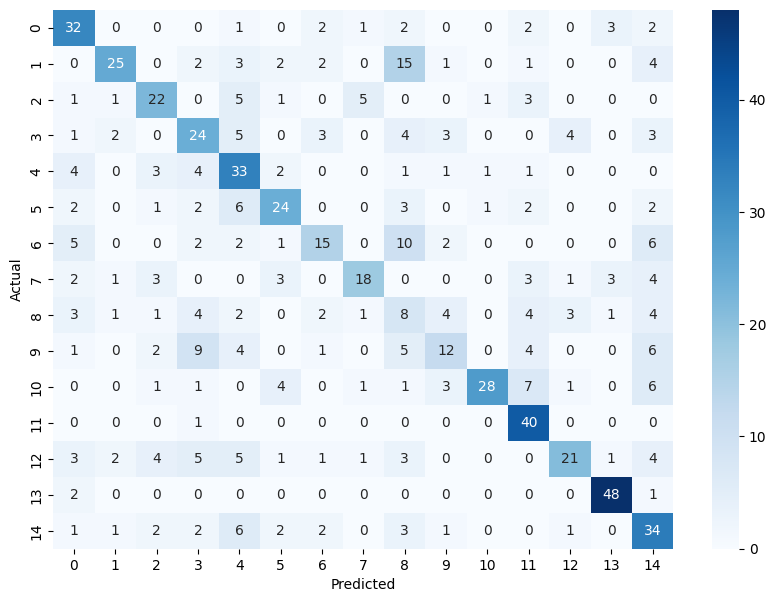

In [19]:
evaluation(df_openai_predicted)

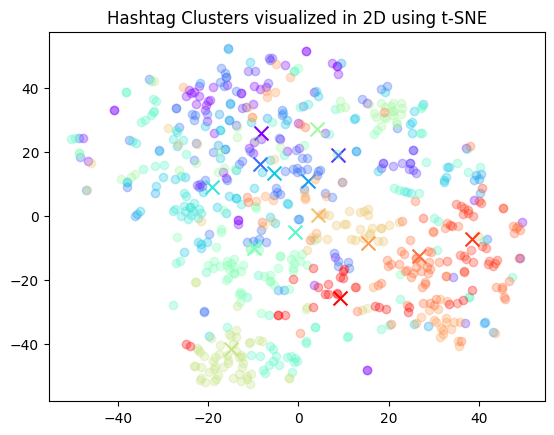

In [20]:
visualized_in_2d(df_openai_predicted)

### ELECTRA Discriminatorを使ったカテゴリ分類

In [21]:
from transformers import ElectraModel, ElectraTokenizer

class ELECTRAModel(EmbeddingModel):
    def __init__(self, model_name="Cinnamon/electra-small-japanese-discriminator"):
        self.tokenizer = ElectraTokenizer.from_pretrained(model_name)
        self.model = ElectraModel.from_pretrained(model_name)
        
    def convert_to_vector(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
        vector = outputs.last_hidden_state[0, 0, :].numpy().tolist()
        return vector

In [22]:
# # 1回目のみ
# electra_model = ELECTRAModel()

# # ハッシュタグをベクトル変換してcsv出力
# df_electra = add_vector_column(df, electra_model, 'hashtag')
# df_electra.to_csv('output/hashtags_electra.csv', index=False)

# # カテゴリをベクトル変換してcsv出力
# df_category_electra = add_vector_column(df_category, electra_model, 'category')
# df_category_electra.to_csv('output/categories_electra.csv', index=False)

print('Elapsed time: 6.9658660888671875 seconds')
print('Elapsed time: 0.17353558540344238 seconds')

Elapsed time: 6.9658660888671875 seconds
Elapsed time: 0.17353558540344238 seconds


In [23]:
# 2回目以降
df_electra = pd.read_csv('output/hashtags_electra.csv')
df_category_electra = pd.read_csv('output/categories_electra.csv')

In [24]:
# # 1回目のみ
# df_electra_predicted = predict_category(df_electra, df_category_electra)
# df_electra_predicted.to_csv('output/hashtags_electra_predicted.csv', index=False)

In [25]:
# 2回目以降
df_electra_predicted = pd.read_csv('output/hashtags_electra_predicted.csv')
df_electra_predicted.head()

,hashtag,category,hashtag_vector,predict_category,cosine_similarity
0,サッカー,スポーツ,"[0.13371697068214417, -0.1004251167178154, -0....",スポーツ,0.987979
1,野球,スポーツ,"[0.14963242411613464, -0.05383671447634697, -0...",スポーツ,0.988140
2,ラグビー,スポーツ,"[0.1806260645389557, -0.05859542265534401, -0....",スポーツ,0.982508
3,マラソン,スポーツ,"[0.06707974523305893, -0.08123189210891724, -0...",スポーツ,0.988446
4,バレーボール,スポーツ,"[0.12521228194236755, -0.16276894509792328, -0...",スポーツ,0.987713


Accuracy: 0.19
Precision: 0.19
Recall: 0.18
F1 Score: 0.16


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


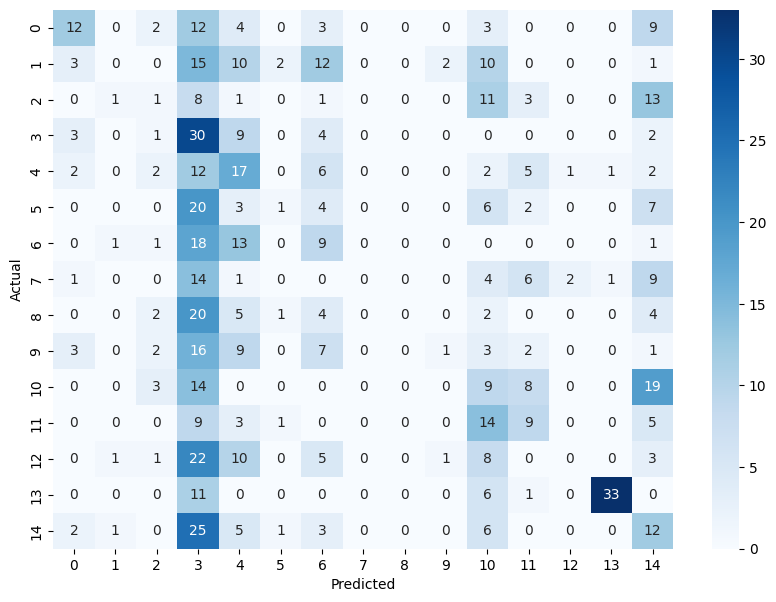

In [26]:
evaluation(df_electra_predicted)

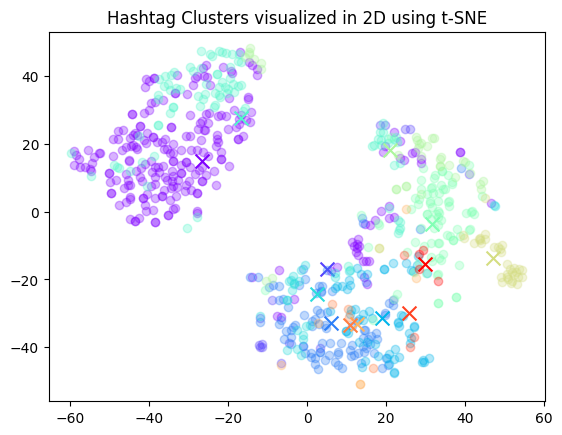

In [27]:
visualized_in_2d(df_electra_predicted)

## まとめ

ハッシュタグのカテゴリ分類の結果をモデルごとに比較します。

| Model               | Accuracy | Precision | Recall | F1 Score | Elapsed time |
|---------------------|----------|-----------|--------|----------|----------|
| BERT                | 0.12     | 0.15      | 0.12   | 0.12     | 33.40 seconds|
| OpenAI Embedding API| 0.55     | 0.58      | 0.55   | 0.54     | 258.63 seconds|
| ELECTRA Discriminator | 0.19     | 0.19      | 0.18   | 0.16     |  7.14 seconds |

予測精度においては、OpenAI Embedding APIがすべての評価指標で最も優れた結果になりました。今回は`Ada v2`モデルを使用しましたが、これはEmbedding APIの中では最も安価なモデルです。他のモデルでは結果が異なるかもしれません。

BERTとその後継のELECTRAを比較すると、やはりELECTRAのほうが性能は高いようです。今回は日本語版のWikipediaで事前学習済みのモデルを使用しました。しかし、Fine turningなしの状態ではOpenAI Embedding APIのほうが圧倒的に優れている結果となりました。

OpenAI Embedding APIはリクエストのたびに費用がかかりますが、今回695個の日本語のハッシュタグをベクトル変換して消費したトークンは合計3830、計算が正しければ $0.000383（= 0.055 円）なので非常に安価です。